In [1]:
from astropy.table import Table

from scipy.ndimage import gaussian_filter1d

import os

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
mpl.rc('font', size=16)
mpl.rc('figure', max_open_warning = 0)

In [3]:
lensdet = Table.read('silo_eboss_detections-1.0.1.fits', 'DETECTIONS')
lensdet

CATALOG_ID,EMLINE_SCAN_TYPE,DETECTION_Z,N_EMLINES_SN_GE4,QUADATURE_SUM_SN_GE3,SPECTRA_GRADE,TOTAL_GRADE,COMMENT,FIRST_DETECTION_FROM,FIRST_DETECTION_LG,SDSS_TARGET_NAME,PLATE,MJD,FIBER_INDEX,SDSS_SURVEY,BESTOBJID,SPECOBJID,CLASS_NOQSO,OBJCLASS,TARGET_GALAXY_TYPE,TARGETOBJID,Z_NOQSO,ZERR_NOQSO,ZWARNING_NOQSO,RA,DEC,RA_HMS,DEC_DMS,WAVE,FLUX,IVAR,AND_MASK,OR_MASK,SKY,WDISP,MODEL_SILO,IVAR_RESCALED,RESIDUAL_FLUX,SN_SPECTRA_SG
,,,,,,,,,,,,,,,,,,,,,,,,Degree,Degree,hour:':'',Degree:':'',Angstroms,10^-17 ergs/s/cm^2/Ang,,,,10^-17 ergs/s/cm^2/Ang,pixel=dloglam,10^-17 ergs/s/cm^2/Ang,,10^-17 ergs/s/cm^2/Ang,
int32,bytes10,float32,int32,float32,bytes2,bytes2,bytes3000,bytes30,bytes20,bytes20,int32,int32,int32,bytes10,bytes30,bytes30,bytes10,bytes15,bytes15,bytes30,float32,float32,int32,float32,float32,bytes13,bytes13,object,object,object,object,object,object,object,object,object,object,object
0,Single-lin,1.6161817,1,6.6698523,B-,B-,"Discernable OII(b, a). Emission-line is unusually wide. Potential sky contamination near OII(b, a). Sky emissions located near the left side of the candidate emission-line is approximate or greater than 30 X 10^-17 ergs/s/cm^2/Ang. Occurance of passed first-inspection detections observed in the restframe near the center of the candidate emission-line is significantly more common than the local median around OII(b, a).",,,SDSS J0203-0022,3609,55201,306,BOSS,1237663783673987836,4063456963694186496,GALAXY,GALAXY,LRG,1237663783673987836,0.502251,9.89343e-05,0,30.799484,-0.3763533,02:03:11.88,-00:22:34.87,[ 3562.8704 3563.69 3564.5117 ... 10280.165 10282.535 10284.8955],[-4.9880185 0.80759656 6.6038046 ... 0.50665027 6.3634706 5.6943765 ],[0.01710885 0. 0.02650832 ... 0.45362827 0.1413292 0.02641163],[ 0 0 0 ... 0 0 8388608],[ 71303168 0 0 ... 0 75497472 209977344],[ 15.804016 16.442059 15.893091 ... 16.10707 64.22136 257.31174 ],[1.4076935 1.3878634 1.3834217 ... 0.8628123 0.86823356 0.87524164],[0.2676132 0.2579444 0.25080878 ... 2.1102476 2.104876 2.143719 ],[0.00955132 0. 0.01216841 ... 0. 0. 0. ],[-5.255632 0.54965216 6.352996 ... -1.6035973 4.2585945 3.5506575 ],[0. 0.53694767 1.1398557 ... 0. 0. 0. ]
1,Single-lin,1.0949216,1,9.1318,B+,B+,"Discernable OII(b, a). The shape of the OII(b, a) doublet best matches a double Gaussian. Potential sky contamination near OII(b, a). Sky emissions located near the center of the candidate emission-line is approximate or less than 20 X 10^-17 ergs/s/cm^2/Ang. Sky emissions located near the right side of the candidate emission-line is approximate or greater than 30 X 10^-17 ergs/s/cm^2/Ang.",,,SDSS J0209+0014,3609,55201,993,BOSS,1237666408456585898,4063645804816257024,GALAXY,GALAXY,LRG,1237666408456585898,0.466849,0.000216761,0,32.393986,0.24629664,02:09:34.56,+00:14:46.67,[ 3579.3164 3580.14 3580.9636 ... 10339.515 10341.887 10344.272 ],[ 4.5368304 -0.50737226 -0.6995979 ... 4.2998624 7.8837705 4.9376183 ],[0.0279741 0.03135892 0.03061443 ... 0.15029718 0.14717561 0.13791645],[0 0 0 ... 0 0 0],[ 0 0 0 ... 851968 0 8388608],[19.96744 19.570675 19.311747 ... 15.515409 16.404514 26.430988],[1.4677151 1.4735433 1.46747 ... 0.8904149 0.8906404 0.89274424],[0.53579366 0.5280756 0.5283308 ... 2.2352664 2.2304187 2.3702517 ],[0.02286307 0.02689086 0.02614893 ... 0.15029718 0.14717561 0.13791645],[ 4.0010366 -1.0354478 -1.2279288 ... 2.064596 5.653352 2.5673666],[0.33928362 0.06370619 0. ... 2.3645952 2.6302574 2.2479517 ]
2,Single-lin,1.5093884,1,7.4631968,B-,B-,"Emergent OII(b, a). The shape of the OII(b, a) doublet best matches a double Gaussian. Potential sky contamination near OII(b, a). Sky emissions located near the left side of the candidate emission-line is approximate or less than 20 X 10^-17 ergs/s/cm^2/Ang.",,,SDSS J0230-0032,3615,56544,142,BOSS,1237657070089864024,4070167305690304512,GALAXY,GALAXY,LRG,1237657070089864024,0.613123,0.000126437,0,37.707367,-0.5432817,02:30:49.77,-00:32:35.81,[ 3565.3318 3566.1538 3566.9744 ... 10344.272 10346.657 10349.043 ],[17.525759 

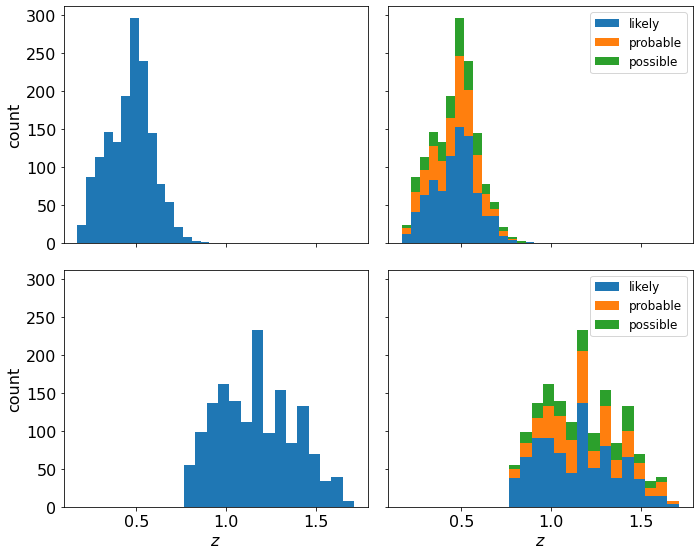

In [4]:
likely = np.char.startswith(lensdet['SPECTRA_GRADE'], b'A')
probable = np.char.startswith(lensdet['SPECTRA_GRADE'], b'B')
possible = np.char.startswith(lensdet['SPECTRA_GRADE'], b'C')

zlens = lensdet['Z_NOQSO']
zsrc = lensdet['DETECTION_Z']
nbins = 15

fig, axes = plt.subplots(2,2, figsize=(10,8), sharex=True, sharey=True, tight_layout=True)

ax = axes[0,0]
ax.hist(zlens, bins=nbins)
ax.set(ylabel='count')

ax = axes[0,1]
ax.hist([zlens[likely], zlens[probable], zlens[possible]],
        label=['likely', 'probable', 'possible'],
        bins=nbins, stacked=True)
ax.legend(fontsize=12)

ax = axes[1,0]
ax.hist(zsrc, bins=nbins)
ax.set(xlabel=r'$z$',
       ylabel='count')

ax = axes[1,1]
ax.hist([zsrc[likely], zsrc[probable], zsrc[possible]],
        label=['likely', 'probable', 'possible'],
        bins=nbins, stacked=True)
ax.set(xlabel=r'$z$')
ax.legend(fontsize=12);

In [5]:
def plot_radec(table):
    """Mollweide projection plot adapted to astro coordinates.
    
    Parameters
    ----------
    table : astropy.table.Table
        Data table with secondary target info.
    
    Returns
    -------
    fig : matplotlib.Figure
        Figure object to let user apply further plot manipulation.
    """
    fig, ax = plt.subplots(1,1, figsize=(8,4), subplot_kw={'projection': 'mollweide'})
    
    # Loop through unique classes.
    for grade, class_name in zip([b'A', b'B', b'C'], ['likely', 'probable', 'possible']):
        select = np.char.startswith(table['SPECTRA_GRADE'], grade)
        
        # Convert RA, Dec to radians.
        # Rotate the RA so that the plot goes 360->0 left to right.
        _ra = np.radians(180. - table['RA'][select])
        _dec = np.radians(table['DEC'][select])
        ax.scatter(_ra, _dec, alpha=0.5, s=5, label=class_name)

    # Clean up the plot and return the Figure object.
    ax.set(xticks=np.radians([-150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150]),
           xticklabels=['22h', '20h', '18h', '16h', '14h', '12h', '10h', '8h', '6h', '4h', '2h'])
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.grid(ls=':')
    
    ax.legend(fontsize=10, loc='lower right')
    fig.tight_layout()

    return fig;

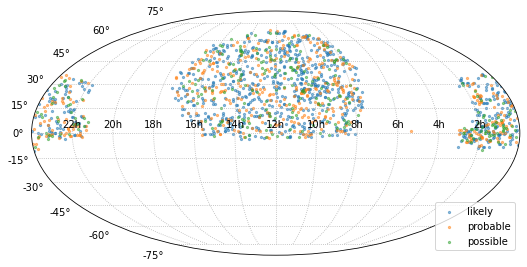

In [6]:
fig = plot_radec(lensdet)

In [7]:
import requests

def get_cutout(idx, ra, dec, verbose=False):
    """Grab and cache legacy survey cutouts.
    
    Parameters
    ----------
    targetid : int
        DESI target ID.
    ra : float
        Right ascension (degrees).
    dec : float
        Declination (degrees).
    verbose : bool
        Add some status messages if true.
        
    Returns
    -------
    img_name : str
        Name of JPG cutout file written after query.
    """
    img_name = 'silo_stronglens_{:04d}.jpg'.format(idx)
    
    if os.path.exists(img_name):
        if verbose:
            print('{} exists.'.format(img_name))
    else:
        if verbose:
            print('Accessing {}'.format(img_name))
        img_url = 'https://www.legacysurvey.org/viewer/cutout.jpg?ra={}&dec={}&%22/pix=0.25&layer=dr8&size=180'.format(ra, dec)
        with open(img_name, 'wb') as handle: 
            response = requests.get(img_url, stream=True) 
            if not response.ok: 
                print(response) 
            for block in response.iter_content(1024): 
                if not block: 
                    break 
                handle.write(block)
    
    return img_name

In [12]:
idx_best = np.argwhere(lensdet['SPECTRA_GRADE'] == b'A+').flatten()
idx = sorted(np.random.choice(idx_best, size=5, replace=False))

In [13]:
# Emission and absorption lines from Prospect tables.
emi_lines = Table.read('emission_lines.txt', format='ascii', comment='#', names=['name','longname','lambda','vacuum','major'])
abs_lines = Table.read('absorption_lines.txt', format='ascii', comment='#', names=['name','longname','lambda','vacuum','major'])

emi_lines_major = emi_lines[emi_lines['major']=='True']
abs_lines_major = abs_lines[abs_lines['major']=='True']

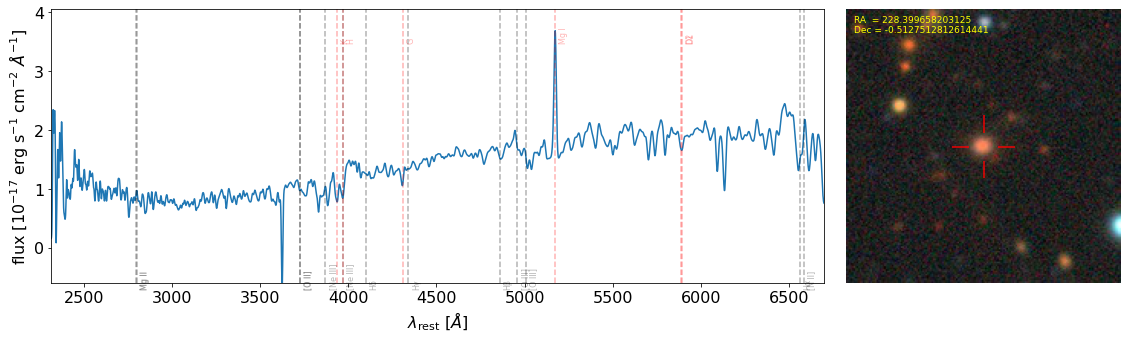

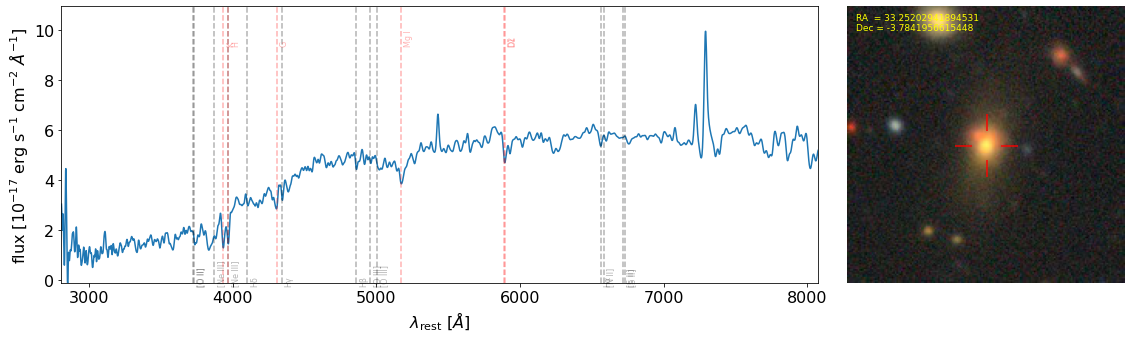

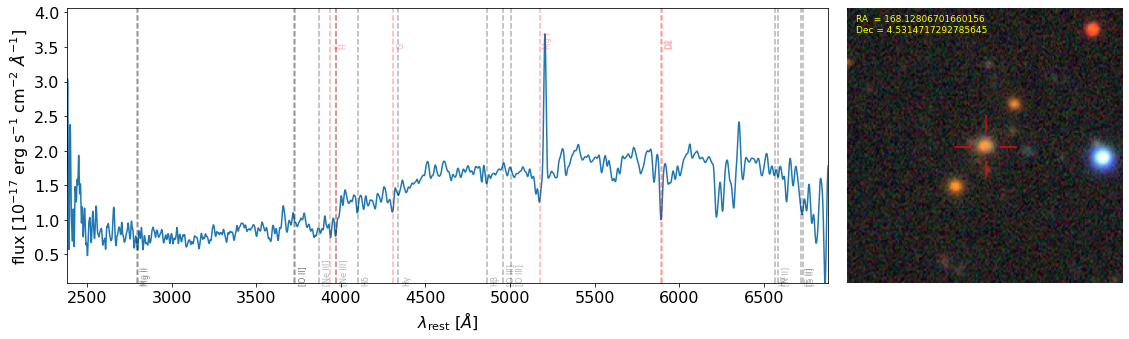

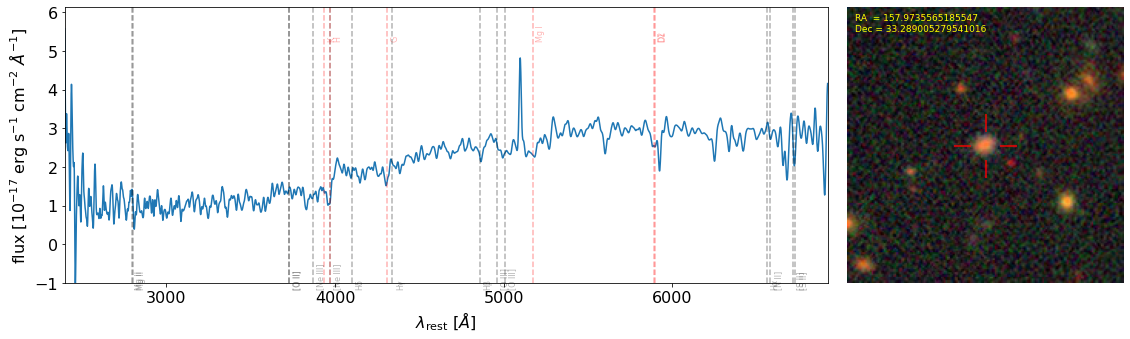

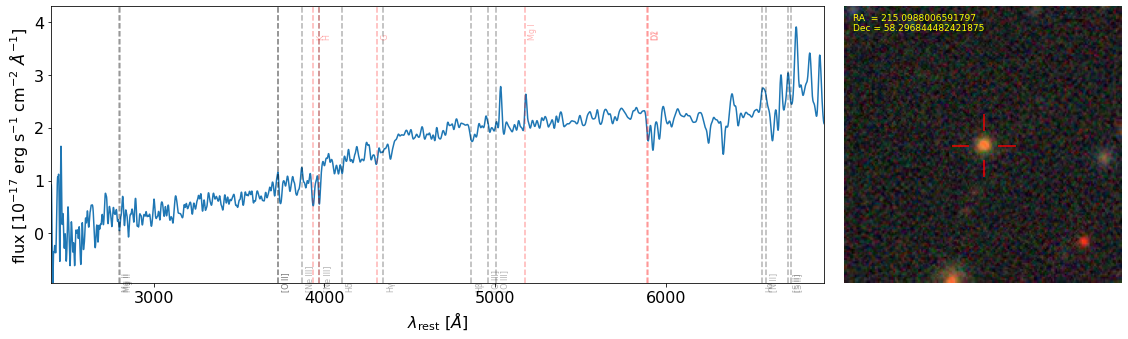

In [14]:
for j in idx:
    fig, axes = plt.subplots(1,2, figsize=(16,5), gridspec_kw={'width_ratios':[3,1.1]},
                         tight_layout=True)
    
    # Plot the spectrum.
    z = lensdet['Z_NOQSO'][j]
    ra = lensdet['RA'][j]
    dec = lensdet['DEC'][j]
    
    wave = lensdet['WAVE'][j][10:-10]
    flux = lensdet['FLUX'][j][10:-10]
    
    restwave = wave / (1+z)
    smoothed = gaussian_filter1d(flux, 5)
    
    fmin = np.min(smoothed)
    fmax = np.max(smoothed)

    ax = axes[0]
    ax.plot(restwave, smoothed)
    
    for eline in emi_lines_major:
        wl = eline['lambda']#*(1 + z)
        if wl > restwave[0] and wl < restwave[-1]:
            ax.axvline(wl, ls='--', color='k', alpha=0.3)
            ax.text(wl+20, fmin, eline['name'], fontsize=8, rotation=90, alpha=0.3)

    for aline in abs_lines_major:
        wl = aline['lambda']#*(1 + z)
        if wl > restwave[0] and wl < restwave[-1]:
            ax.axvline(wl, ls='--', color='r', alpha=0.3)
            ax.text(wl+20, 0.95*fmax, aline['name'], color='r', fontsize=8, rotation=90, alpha=0.3)

    ax.set(xlabel=r'$\lambda_{\mathrm{rest}}$ [$\AA$]',
           xlim=(restwave[0], restwave[-1]),
           ylabel=r'flux [$10^{-17}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]',
           ylim=(0.9*fmin, 1.1*fmax),
#            title=r'{}; $z={:.3f}$ ($\Delta\chi^2={:.5g}$; ZWARN=0x{:x}; SPECTYPE={:s})'.format(toospec.fibermap[i]['TARGETID'], z, dchi2, zwarn, sptype.decode('utf-8')),
          )
    
    # Plot the image cutout.
    ax = axes[1]

    img_file = get_cutout(j, ra, dec)
    img = mpl.image.imread(img_file)

    ax.imshow(img)

    x1, x2, x3, x4 = [90, 90], [70, 80], [90, 90], [100,110]
    y1, y2, y3, y4 = [70, 80], [90, 90], [100,110], [90,90]
    ax.plot(x1, y1, x2, y2, x3, y3, x4, y4, color='r', linewidth=2, alpha=0.7)
    ax.text(5,15, '{:3s} = {}\n{:3s} = {}'.format('RA', ra, 'Dec', dec), color='yellow', fontsize=9)
    ax.set(aspect='equal',)
#            title='{}, Tile {}, Exp {}'.format(obj_exp['NIGHT'], obj['TILEID'], obj_exp['EXPID']))
    ax.axis('off')
    
#     fig.savefig('spec_cutout_{}_{}_{:06d}_{:06d}.png'.format(obj['TARGETID'], obj_exp['NIGHT'], obj['TILEID'], obj_exp['EXPID']), dpi=100)